### 1. Load packages

In [2]:
import time

In [4]:
!pip install tinkoff-investments


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
TOKEN = ''

In [9]:
from tinkoff.invest import Client
#from tinkoff.invest.constants import INVEST_GRPC_API_SANDBOX 


# with Client(TOKEN, target=INVEST_GRPC_API_SANDBOX ) as client:
#     print(client.users.get_accounts())


with Client(TOKEN) as client:
    print(client.users.get_accounts())

GetAccountsResponse(accounts=[Account(id='2169433725', type=<AccountType.ACCOUNT_TYPE_TINKOFF: 1>, name='M13', status=<AccountStatus.ACCOUNT_STATUS_OPEN: 2>, opened_date=datetime.datetime(2022, 4, 27, 0, 0, tzinfo=datetime.timezone.utc), closed_date=datetime.datetime(1970, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), access_level=<AccessLevel.ACCOUNT_ACCESS_LEVEL_READ_ONLY: 2>)])


### 2. Load data

In [15]:
import logging
import os

import pandas as pd

from tinkoff.invest import Client, SecurityTradingStatus
from tinkoff.invest.services import InstrumentsService
from tinkoff.invest.utils import quotation_to_decimal

from IPython.display import clear_output

In [18]:
def get_figi(ticker):
    with Client(TOKEN) as client:
        instruments: InstrumentsService = client.instruments
        tickers = []
        for method in ["shares", "bonds", "etfs", "currencies", "futures"]:
            for item in getattr(instruments, method)().instruments:
                tickers.append(
                    {
                        "name": item.name,
                        "ticker": item.ticker,
                        "class_code": item.class_code,
                        "figi": item.figi,
                        "uid": item.uid,
                        "type": method,
                        "min_price_increment": quotation_to_decimal(
                            item.min_price_increment
                        ),
                        "scale": 9 - len(str(item.min_price_increment.nano)) + 1,
                        "lot": item.lot,
                        "trading_status": str(
                            SecurityTradingStatus(item.trading_status).name
                        ),
                        "api_trade_available_flag": item.api_trade_available_flag,
                        "currency": item.currency,
                        "exchange": item.exchange,
                        "buy_available_flag": item.buy_available_flag,
                        "sell_available_flag": item.sell_available_flag,
                        "short_enabled_flag": item.short_enabled_flag,
                        "klong": quotation_to_decimal(item.klong),
                        "kshort": quotation_to_decimal(item.kshort),
                    }
                )

        tickers_df = pd.DataFrame(tickers)

        ticker_df = tickers_df[tickers_df["ticker"] == ticker]
        #return ticker_df
        if ticker_df.empty:
            print("There is no such ticker: %s", ticker)
            return

        figi = ticker_df["figi"].iloc[0]
        return figi


def get_info():
    with Client(TOKEN) as client:
        instruments: InstrumentsService = client.instruments
        tickers = []
        for method in ["shares", "bonds", "etfs", "currencies", "futures"]:
            for item in getattr(instruments, method)().instruments:
                tickers.append(
                    {
                        "name": item.name,
                        "ticker": item.ticker,
                        "class_code": item.class_code,
                        "figi": item.figi,
                        "uid": item.uid,
                        "type": method,
                        "min_price_increment": quotation_to_decimal(
                            item.min_price_increment
                        ),
                        "scale": 9 - len(str(item.min_price_increment.nano)) + 1,
                        "lot": item.lot,
                        "trading_status": str(
                            SecurityTradingStatus(item.trading_status).name
                        ),
                        "api_trade_available_flag": item.api_trade_available_flag,
                        "currency": item.currency,
                        "exchange": item.exchange,
                        "buy_available_flag": item.buy_available_flag,
                        "sell_available_flag": item.sell_available_flag,
                        "short_enabled_flag": item.short_enabled_flag,
                        "klong": quotation_to_decimal(item.klong),
                        "kshort": quotation_to_decimal(item.kshort),
                    }
                )

        tickers_df = pd.DataFrame(tickers)
    return tickers_df

In [21]:
import os
from datetime import timedelta
import datetime

from tqdm import tqdm
import numpy as np

from tinkoff.invest import CandleInterval, Client
from tinkoff.invest.utils import now

    
def get_all_candles(ticker=None, from_=None, to_=None, interval=None):
    
    figi = get_figi(ticker)
    
    with Client(TOKEN) as client:
        
        data = [elem for elem in client.get_all_candles(figi=figi, 
                                      from_=from_-timedelta(hours=3),
                                      to=to_- timedelta(hours=3),
                                     interval=interval
                                    )
               ]

    
    #open_ = np.zeros(len(data))
    #high = np.zeros(len(data))
    #low = np.zeros(len(data))
    close = np.zeros(len(data))
    volume = np.zeros(len(data))
    times = np.zeros(len(data), dtype='O')
    for i, elem in enumerate(data):
        #open_[i] = quotation_to_decimal(elem.open)
        #high[i] = quotation_to_decimal(elem.high)
        #low[i] = quotation_to_decimal(elem.low)
        close[i] = quotation_to_decimal(elem.close)
        volume[i] = elem.volume
        times[i] = elem.time


    df = pd.DataFrame({'time' : times,
                      #'open' : open_,
                      'close' : close,
                      'volume' : volume,
                      #'low' : low,
                      #'high' : high
                    })
    df['time'] += pd.Timedelta(hours=3)
    return df

### -1


In [25]:
get_figi('SFIN')

'BBG003LYCMB1'

In [26]:
ticker = 'T'
#2024-06-10 
data = get_all_candles(ticker=ticker,
                       from_=datetime.datetime(2024, 6, 10, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 6, 12, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )

data['ticker'] = ticker
data

,time,close,volume,ticker
0,2024-06-10 09:00:00+00:00,2974.0,1846.0,T
1,2024-06-10 10:00:00+00:00,2989.0,252336.0,T
2,2024-06-10 11:00:00+00:00,2976.0,106799.0,T
3,2024-06-10 12:00:00+00:00,2977.6,139763.0,T
4,2024-06-10 13:00:00+00:00,2973.6,64276.0,T
5,2024-06-10 14:00:00+00:00,2974.0,66350.0,T
6,2024-06-10 15:00:00+00:00,2948.6,133118.0,T
7,2024-06-10 16:00:00+00:00,2947.0,69133.0,T
8,2024-06-10 17:00:00+00:00,2930.6,86918.0,T
9,2024-06-10 18:00:00+00:00,2898.0,161966.0,T


In [29]:
data = get_all_candles(ticker=ticker,
                       from_=datetime.datetime(2024, 6, 10, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2024, 6, 12, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_DAY
                      )

data['ticker'] = ticker
data

,time,close,volume,ticker
0,2024-06-10 03:00:00+00:00,2886.6,1391052.0,T
1,2024-06-11 03:00:00+00:00,2890.6,1160771.0,T


### -1

In [34]:
%%time

ticker = 'TMOS'

data = get_all_candles(ticker=ticker,
                       from_=datetime.datetime(2025, 1, 1, tzinfo=datetime.timezone.utc),
                       to_=datetime.datetime(2025, 1, 10, tzinfo=datetime.timezone.utc),
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )

data['ticker'] = ticker

CPU times: user 814 ms, sys: 24.4 ms, total: 839 ms
Wall time: 1.82 s


In [35]:
data

,time,close,volume,ticker
0,2025-01-03 09:00:00+00:00,6.31,81165.0,TMOS
1,2025-01-03 10:00:00+00:00,6.20,12405231.0,TMOS
2,2025-01-03 11:00:00+00:00,6.19,4224743.0,TMOS
3,2025-01-03 12:00:00+00:00,6.14,5029243.0,TMOS
4,2025-01-03 13:00:00+00:00,6.14,4735730.0,TMOS
5,2025-01-03 14:00:00+00:00,6.14,6350496.0,TMOS
6,2025-01-03 15:00:00+00:00,6.14,1389740.0,TMOS
7,2025-01-03 16:00:00+00:00,6.14,2190425.0,TMOS
8,2025-01-03 17:00:00+00:00,6.15,2098042.0,TMOS
9,2025-01-03 18:00:00+00:00,6.15,695071.0,TMOS


In [37]:
!mkdir data

mkdir: data: File exists


In [38]:
!mkdir data/raw

mkdir: data/raw: File exists


In [39]:
!mkdir data/raw/15min

mkdir: data/raw/15min: File exists


In [40]:
!mkdir data/raw/1hour

mkdir: data/raw/1hour: File exists


In [43]:
!mkdir data/raw/1day

mkdir: data/raw/1day: File exists


In [51]:
import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

### Отберем ликвидные акции

In [56]:
stocks = ['AFLT',
 'IRAO',
 'MVID',
 'OGKB',
 'SPBE',
 'MTLRP',
 'SFIN',
 'KMAZ',
 'CBOM',
 'MSNG',
 'FEES',
 'LKOH',
 'FESH',
 'KROT',
 'LENT',
 'MDMG',
 'NKNCP',
 'VKCO',
 'UPRO',
 'MRKY',
 'SELG',
 'SGZH',
 'AKRN',
 'CHMK',
 'ENPG',
 'YAKG',
 'PMSBP',
 'RKKE',
 'GEMC',
 'LSRG',
 'MRKZ',
 'BANE',
 'CNTL',
 'PMSB',
 'KRKNP',
 'NMTP',
 'PLZL',
 'TATN',
 'AFKS',
 'UNKL',
 'APTK',
 'LNZL',
 'GMKN',
 'NSVZ',
 'LIFE',
 'RNFT',
 'VRSB',
 'YDEX',
 'UWGN',
 'TGKN',
 'ABRD',
 'HYDR',
 'ABIO',
 'WUSH',
 'RTKMP',
 'GTRK',
 'NLMK',
 'TATNP',
 'CNTLP',
 'BLNG',
 'ALRS',
 'GCHE',
 'VSMO',
 'LSNG',
 'TRNFP',
 'MGNT',
 'RENI',
 'NKHP',
 'TGKB',
 'ROLO',
 'IRKT',
 'MGTSP',
 'MTLR',
 'TGKA',
 'MSRS',
 'HEAD',
 'RUAL',
 'MRKV',
 'KLSB',
 'SIBN',
 'SNGS',
 'MSTT',
 'KAZTP',
 'DVEC',
 'NVTK',
 'RASP',
 'VTBR',
 'PHOR',
 'TTLK',
 'NKNC',
 'T',
 'KAZT',
 'AMEZ',
 'MRKU',
 'TRMK',
 'MOEX',
 'SBERP',
 #'VEON-RX',
 'CHMF',
 'RTKM',
 'SMLT',
 'LNZLP',
 'MRKC',
 'MRKP',
 'UNAC',
 'KZOSP',
 'GAZP',
 'ROSN',
 'BELU',
 'ELFV',
 'FLOT',
 'PIKK',
 'LSNGP',
 'SVAV',
 'TGKBP',
 'POSI',
 'KZOS',
 'MRKS',
 'SNGSP',
 'MTSS',
 'MAGN',
 'PRFN',
 'SBER',
 'BANEP',
 'BSPB',
 'AQUA',
 'RBCM']

In [103]:
data = []
for stock in stocks:
    df = load_pkl(f"../money_v3/data/raw/1day/{stock}.pkl")
    df = df[df['time'] > datetime.datetime(2025, 1, 1, tzinfo=datetime.timezone.utc)]
    data += [df]
data = pd.concat(data)

data = data.groupby('ticker').apply(lambda x: pd.Series({'mean_volume' :  x['volume'].mean(),
                                                         'mean_close' : x['close'].mean()}))
data

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_5127/1407591603.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('ticker').apply(lambda x: pd.Series({'mean_volume' :  x['volume'].mean(),


,mean_volume,mean_close
ticker,,
ABIO,1.996380e+05,90.305455
ABRD,1.130664e+04,186.772727
AFKS,1.342772e+06,14.786773
AFLT,3.610632e+06,61.276818
AKRN,4.325909e+02,17686.636364
...,...,...
VSMO,4.774318e+03,26984.545455
VTBR,3.338885e+07,82.817727
WUSH,1.913978e+06,180.944545


In [105]:
data_info = get_info()
data_info

,name,ticker,class_code,figi,uid,type,min_price_increment,scale,lot,trading_status,api_trade_available_flag,currency,exchange,buy_available_flag,sell_available_flag,short_enabled_flag,klong,kshort
0,CNX Resources Corporation,CNX,SPBXM,BBG000CKVSG8,82f8d11f-0307-45c3-bb94-8758a2f673a3,shares,0.01000000,2,1,SECURITY_TRADING_STATUS_NOT_AVAILABLE_FOR_TRADING,True,usd,unknown,False,False,False,0E-8,0E-8
1,SLM Corp,SLM,SPBXM,BBG000BBCQD7,f8e85601-10e3-4af6-a44b-b7d2ca3f7f62,shares,0.01000000,2,1,SECURITY_TRADING_STATUS_NOT_AVAILABLE_FOR_TRADING,True,usd,unknown,False,False,False,0E-8,0E-8
2,Axcelis Technologies,ACLS,SPBXM,BBG000DW34S2,98da7119-dc33-4567-ae41-1944f6f49334,shares,0.01000000,2,1,SECURITY_TRADING_STATUS_NOT_AVAILABLE_FOR_TRADING,True,usd,unknown,False,False,False,0E-8,0E-8
3,Amphastar Pharmaceuticals,AMPH,SPBXM,BBG000BW90S6,c1ad8284-45de-468f-8a37-271f254ae601,shares,0.01000000,2,1,SECURITY_TRADING_STATUS_NOT_AVAILABLE_FOR_TRADING,True,usd,unknown,False,False,False,0E-8,0E-8
4,Remitly Global,RELY,SPBXM,BBG012C7JST2,fb4f9c78-ba9a-4733-be60-50d6eacea5e0,shares,0.01000000,2,1,SECURITY_TRADING_STATUS_NOT_AVAILABLE_FOR_TRADING,True,usd,unknown,False,False,False,0E-8,0E-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3802,BANE-6.25 Башнефть,BNM5,SPBFUT,FUTBANE06250,a4811010-1dcf-4bb3-ac83-4c83a507834e,futures,1.00000000,9,1,SECURITY_TRADING_STATUS_BREAK_IN_TRADING,True,rub,FORTS_EVENING,True,True,True,2.00000000,2.00000000
3803,MMI-6.25 Индекс Металлов и добычи,MAM5,SPBFUT,FUTMMI062500,742d7110-045f-4166-b24f-6019b385eeba,futures,1.00000000,9,1,SECURITY_TRADING_STATUS_BREAK_IN_TRADING,True,rub,FORTS_EVENING,True,True,True,2.00000000,2.00000000
3804,RTSM-9.25 Индекс РТС (мини),RMU5,SPBFUT,FUTRTSM09250,106e6bcb-627d-4ad7-8e96-141527bbdbd1,futures,0.50000000,1,1,SECURITY_TRADING_STATUS_BREAK_IN_TRADING,True,rub,FORTS_EVENING,True,True,True,2.00000000,2.00000000
3805,BR-5.25 Нефть Brent,BRK5,SPBFUT,FUTBR0525000,162b7aab-c5b1-45d2-9353-363dad9510c1,futures,0.01000000,2,1,SECURITY_TRADING_STATUS_BREAK_IN_TRADING,True,rub,FORTS_EVENING,True,True,True,2.00000000,2.00000000


In [112]:
data = data.merge(data_info[['ticker', 'lot']], on='ticker', how='left')
data

,ticker,mean_volume,mean_close,lot
0,ABIO,1.996380e+05,90.305455,10
1,ABRD,1.130664e+04,186.772727,10
2,AFKS,1.342772e+06,14.786773,100
3,AFLT,3.610632e+06,61.276818,10
4,AKRN,4.325909e+02,17686.636364,1
...,...,...,...,...
122,VSMO,4.774318e+03,26984.545455,1
123,VTBR,3.338885e+07,82.817727,1
124,WUSH,1.913978e+06,180.944545,1
125,YAKG,1.640250e+04,57.956818,10


In [114]:
data['ticker'].value_counts()

ticker
T        2
ABIO     1
SBER     1
RTKMP    1
RTKM     1
        ..
KMAZ     1
KLSB     1
KAZTP    1
KAZT     1
YDEX     1
Name: count, Length: 126, dtype: int64

In [120]:
data['liquid_cap'] = data['mean_volume']*data['mean_close']*data['lot'] / 1e6
data

,ticker,mean_volume,mean_close,lot,liquid_cap
0,ABIO,1.996380e+05,90.305455,10,180.283962
1,ABRD,1.130664e+04,186.772727,10,21.117713
2,AFKS,1.342772e+06,14.786773,100,1985.526372
3,AFLT,3.610632e+06,61.276818,10,2212.480267
4,AKRN,4.325909e+02,17686.636364,1,7.651078
...,...,...,...,...,...
122,VSMO,4.774318e+03,26984.545455,1,128.832806
123,VTBR,3.338885e+07,82.817727,1,2765.188624
124,WUSH,1.913978e+06,180.944545,1,346.323896
125,YAKG,1.640250e+04,57.956818,10,9.506367


In [122]:
pd.set_option('display.max_rows', 130)
data.sort_values(by='liquid_cap')

,ticker,mean_volume,mean_close,lot,liquid_cap
35,KAZTP,3.508182e+02,502.295455,10,1.762144
38,KRKNP,2.972727e+02,8138.181818,1,2.419260
111,TGKBP,2.645591e+03,0.012511,100000,3.309995
81,PMSBP,1.288591e+03,280.963636,10,3.620472
18,CNTLP,5.573682e+03,7.618182,100,4.246132
34,KAZT,8.894545e+02,500.509091,10,4.451801
41,KZOSP,2.155391e+04,21.179091,10,4.564922
46,LNZLP,2.721591e+03,1785.227273,1,4.858658
16,CHMK,7.711818e+02,7128.863636,1,5.497650
53,MGTSP,7.077136e+03,871.818182,1,6.169976


In [132]:
(data['liquid_cap'] > 100).sum() - 1 # 100млн руб

66

In [134]:
data.loc[data['liquid_cap'] > 100, 'ticker'].tolist()

['ABIO',
 'AFKS',
 'AFLT',
 'ALRS',
 'BANEP',
 'BELU',
 'BSPB',
 'CHMF',
 'ENPG',
 'FEES',
 'FESH',
 'FLOT',
 'GAZP',
 'GMKN',
 'GTRK',
 'HEAD',
 'HYDR',
 'IRAO',
 'IRKT',
 'LKOH',
 'LSRG',
 'MAGN',
 'MDMG',
 'MGNT',
 'MOEX',
 'MTLR',
 'MTLRP',
 'MTSS',
 'MVID',
 'NLMK',
 'NMTP',
 'NVTK',
 'PHOR',
 'PIKK',
 'PLZL',
 'POSI',
 'RASP',
 'RNFT',
 'ROSN',
 'RTKM',
 'RUAL',
 'SBER',
 'SBERP',
 'SELG',
 'SFIN',
 'SGZH',
 'SIBN',
 'SMLT',
 'SNGS',
 'SNGSP',
 'SPBE',
 'SVAV',
 'T',
 'T',
 'TATN',
 'TATNP',
 'TGKN',
 'TRMK',
 'TRNFP',
 'UNAC',
 'UPRO',
 'UWGN',
 'VKCO',
 'VSMO',
 'VTBR',
 'WUSH',
 'YDEX']

# 1. Get data

In [60]:
stocks = [

 'ABIO',
 'AFKS',
 'AFLT',
 'ALRS',
 'BANEP',
 'BELU',
 'BSPB',
 'CHMF',
 'ENPG',
 'FEES',
 'FESH',
 'FLOT',
 'GAZP',
 'GMKN',
 'GTRK',
 'HEAD',
 'HYDR',
 'IRAO',
 'IRKT',
 'LKOH',
 'LSRG',
 'MAGN',
 'MDMG',
 'MGNT',
 'MOEX',
 'MTLR',
 'MTLRP',
 'MTSS',
 'MVID',
 'NLMK',
 'NMTP',
 'NVTK',
 'PHOR',
 'PIKK',
 'PLZL',
 'POSI',
 'RASP',
 'RNFT',
 'ROSN',
 'RTKM',
 'RUAL',
 'SBER',
 'SBERP',
 'SELG',
 'SFIN',
 'SGZH',
 'SIBN',
 'SMLT',
 'SNGS',
 'SNGSP',
 'SPBE',
 'SVAV',
 'T',
 'TATN',
 'TATNP',
 'TGKN',
 'TRMK',
 'TRNFP',
 'UNAC',
 'UPRO',
 'UWGN',
 'VKCO',
 'VSMO',
 'VTBR',
 'WUSH',
 'YDEX',    
 'X5',


'TMOS',
]

start = datetime.datetime(2022, 5, 1, tzinfo=datetime.timezone.utc)
end = datetime.datetime(2025, 2, 18, tzinfo=datetime.timezone.utc)

In [62]:
len(stocks) #stocks + TMOS

68

In [1]:
#15min

# for stock in tqdm(stocks):
#     flag_data = False
#     while not flag_data:
#         try:
#             data = get_all_candles(ticker=stock,
#                        from_=start,
#                        to_=end,
#                        interval=CandleInterval.CANDLE_INTERVAL_15_MIN
#                       )
#             flag_data = True
#         except:
            
#             print('Error: flag_data')
#             time.sleep(5)
#     clear_output()

#     data['ticker'] = stock
#     dump_pkl(data, f"./data/raw/15min/{stock}.pkl")

#проблемы со сборкой данных на стороне сервера Т-банка
for stock in tqdm(stocks[1:]):
    flag_data1 = False
    while not flag_data1:
        try:
            data1 = get_all_candles(ticker=stock,
                               from_=start,
                               to_=datetime.datetime(2023, 5, 1, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_15_MIN
                              )
            flag_data1 = True
        except:
            print('Error: flag_data1')
            time.sleep(5)

    
    flag_data2 = False
    while not flag_data2:
        try:            
            data2 = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2023, 5, 1, tzinfo=datetime.timezone.utc),
                               to_=datetime.datetime(2024, 5, 1, tzinfo=datetime.timezone.utc),
                               interval=CandleInterval.CANDLE_INTERVAL_15_MIN
                              )
            flag_data2 = True
        except:
            print('Error: flag_data2')
            time.sleep(5)

    
    flag_data3 = False
    while not flag_data3:
        try:            
            data3 = get_all_candles(ticker=stock,
                               from_=datetime.datetime(2024, 5, 1, tzinfo=datetime.timezone.utc),
                               to_=end,
                               interval=CandleInterval.CANDLE_INTERVAL_15_MIN
                              )
            flag_data3 = True
        except:
            print('Error: flag_data3')
            time.sleep(5)
    
    
    
    clear_output()
    data = pd.concat([data1, data2, data3])
    data.sort_values(by='time', inplace=True)
    data.reset_index(drop=True, inplace=True)


    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/15min/{stock}.pkl")

NameError: name 'tqdm' is not defined

In [82]:
#1hour
for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:
            data = get_all_candles(ticker=stock,
                       from_=start,
                       to_=end,
                       interval=CandleInterval.CANDLE_INTERVAL_HOUR
                      )
            flag_data = True
        except:
            print('Error: flag_data')
            time.sleep(5)

    clear_output()

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1hour/{stock}.pkl")

100%|█████████████████████████████████████████████████████████████████████████| 68/68 [19:58<00:00, 17.62s/it]


In [84]:
#1day
for stock in tqdm(stocks):
    flag_data = False
    while not flag_data:
        try:
            data = get_all_candles(ticker=stock,
                               from_=start,
                               to_=end,
                               interval=CandleInterval.CANDLE_INTERVAL_DAY)
            flag_data = True
        except:
            print('Error: flag_data')
            time.sleep(3)

    clear_output()

    data['ticker'] = stock
    dump_pkl(data, f"./data/raw/1day/{stock}.pkl")

100%|█████████████████████████████████████████████████████████████████████████| 68/68 [02:07<00:00,  1.87s/it]


### 4. Preproc data

* Оставляем только будни
* И часы основных торгов - 10:00–23
* Добавим к акциям IMOEX

In [94]:
!mkdir data/preproc

mkdir: data/preproc: File exists


In [96]:
!mkdir data/preproc/15min

mkdir: data/preproc/15min: File exists


In [98]:
!mkdir data/preproc/1hour

mkdir: data/preproc/1hour: File exists


In [100]:
!mkdir data/preproc/1day

mkdir: data/preproc/1day: File exists


In [106]:
stock = "TMOS"
data_tmos = load_pkl(f"./data/raw/15min/{stock}.pkl")
data_tmos

,time,close,volume,ticker
0,2022-05-04 09:45:00+00:00,4.31,4415.0,TMOS
1,2022-05-04 10:00:00+00:00,4.30,1658871.0,TMOS
2,2022-05-04 10:15:00+00:00,4.32,831422.0,TMOS
3,2022-05-04 10:30:00+00:00,4.29,573727.0,TMOS
4,2022-05-04 10:45:00+00:00,4.27,575417.0,TMOS
...,...,...,...,...
37975,2025-02-17 22:45:00+00:00,7.30,2266496.0,TMOS
37976,2025-02-17 23:00:00+00:00,7.30,523305.0,TMOS
37977,2025-02-17 23:15:00+00:00,7.31,382768.0,TMOS
37978,2025-02-17 23:30:00+00:00,7.33,432933.0,TMOS


In [108]:
#15 min
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

def preproc(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    mask_volume = np.array(datetime.time(10, 0) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data
    


#15 min
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/15min/{stock}.pkl")

    data_ext = data.merge(data_tmos[['time', 'close']].copy().rename(columns={"close" : "tmos_close"}), how='left', on='time')
    assert data.shape[0] == data_ext.shape[0], 'Error 1'

    data = preproc(data_ext)
    assert data['tmos_close'].isnull().sum() < 2500, 'Error 2'

    data['tmos_close'] = data['tmos_close'].ffill()
    
    dump_pkl(data, f"./data/preproc/15min/{stock}.pkl")



100%|█████████████████████████████████████████████████████████████████████████| 68/68 [00:38<00:00,  1.77it/s]


In [112]:
stock = "TMOS"
data_tmos = load_pkl(f"./data/raw/1hour/{stock}.pkl")
data_tmos

,time,close,volume,ticker
0,2022-05-04 09:00:00+00:00,4.31,4415.0,TMOS
1,2022-05-04 10:00:00+00:00,4.27,3639437.0,TMOS
2,2022-05-04 11:00:00+00:00,4.20,5241412.0,TMOS
3,2022-05-04 12:00:00+00:00,4.22,897694.0,TMOS
4,2022-05-04 13:00:00+00:00,4.21,1120045.0,TMOS
...,...,...,...,...
10163,2025-02-17 19:00:00+00:00,7.23,5664283.0,TMOS
10164,2025-02-17 20:00:00+00:00,7.25,1399466.0,TMOS
10165,2025-02-17 21:00:00+00:00,7.26,2229396.0,TMOS
10166,2025-02-17 22:00:00+00:00,7.30,5179522.0,TMOS


In [113]:
#1hour
for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1hour/{stock}.pkl")

    data_ext = data.merge(data_tmos[['time', 'close']].copy().rename(columns={"close" : "tmos_close"}), how='left', on='time')
    assert data.shape[0] == data_ext.shape[0], 'Error 1'

    data = preproc(data_ext)
    assert data['tmos_close'].isnull().sum() < 500, 'Error 2'

    data['tmos_close'] = data['tmos_close'].ffill()
    
    dump_pkl(data, f"./data/preproc/1hour/{stock}.pkl")

100%|█████████████████████████████████████████████████████████████████████████| 68/68 [00:10<00:00,  6.54it/s]


In [117]:
stock = "TMOS"
data_tmos = load_pkl(f"./data/raw/1day/{stock}.pkl")
data_tmos

,time,close,volume,ticker
0,2022-05-04 03:00:00+00:00,4.18,14090097.0,TMOS
1,2022-05-05 03:00:00+00:00,4.22,9804905.0,TMOS
2,2022-05-06 03:00:00+00:00,4.19,7532579.0,TMOS
3,2022-05-11 03:00:00+00:00,4.22,10235590.0,TMOS
4,2022-05-12 03:00:00+00:00,4.06,9508900.0,TMOS
...,...,...,...,...
705,2025-02-11 03:00:00+00:00,6.64,29662088.0,TMOS
706,2025-02-12 03:00:00+00:00,7.04,104223274.0,TMOS
707,2025-02-13 03:00:00+00:00,7.00,74193948.0,TMOS
708,2025-02-14 03:00:00+00:00,7.02,95233490.0,TMOS


In [118]:
#1 day

def preproc_day_data(data):
    data['time'] = data['time'].apply(lambda x: x.tz_convert(None))
    
    mask_bd = np.array(data['time'].apply(lambda x: is_business_day(x)))
    data = data.loc[mask_bd, :]

    #mask_volume = np.array(datetime.time(10, 0) <= pd.to_datetime(data['time'], format='%H:%M').dt.time)
    #data = data.loc[mask_volume, :]

    data.reset_index(drop=True, inplace=True)

    return data



for stock in tqdm(stocks):
    data = load_pkl(f"./data/raw/1day/{stock}.pkl")

    data_ext = data.merge(data_tmos[['time', 'close']].copy().rename(columns={"close" : "tmos_close"}), how='left', on='time')
    assert data.shape[0] == data_ext.shape[0], 'Error 1'
    
    data = preproc_day_data(data_ext)
    
    assert data['tmos_close'].isnull().sum() < 25, 'Error 2' #праздники, в них индекс не торгуется
    data['tmos_close'] = data['tmos_close'].ffill()
    
    dump_pkl(data, f"./data/preproc/1day/{stock}.pkl")

  0%|                                                                                  | 0/68 [00:00<?, ?it/s]/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_36709/3988053929.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tmos_close'] = data['tmos_close'].ffill()
/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_36709/3988053929.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['tmos_close'] = data['tmos_close'].ffill()
/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T

### 5. Анализ на целостность данных

#### 15 min

In [128]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/15min/{stock}.pkl")

    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    assert df.notnull().all().all(), f'{stock} nulls'
    

100%|████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 460.29it/s]


In [130]:
#Нет дублей и данные отсортированы, нет null's (еще бы)

In [133]:
#Заполняемость

In [135]:


dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/15min/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('15 min')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 617.13it/s]


(2399221, 6)

<Axes: xlabel='diff'>

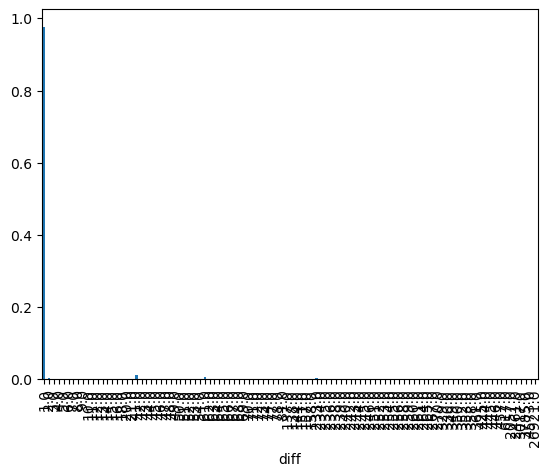

In [137]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [139]:
(df['diff'] < 15).mean()

0.9797701003784145

In [141]:
#Норм

#### 5.3 1hour

In [146]:
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

    assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    assert df.notnull().all().all(), f'{stock} nulls'
    

100%|████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 647.90it/s]


In [148]:
#Нет дублей и данные отсортированы, нет null's (еще бы)

In [151]:
#Заполняемость

In [153]:


dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('1 hour')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|███████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1454.23it/s]


(603649, 6)

<Axes: xlabel='diff'>

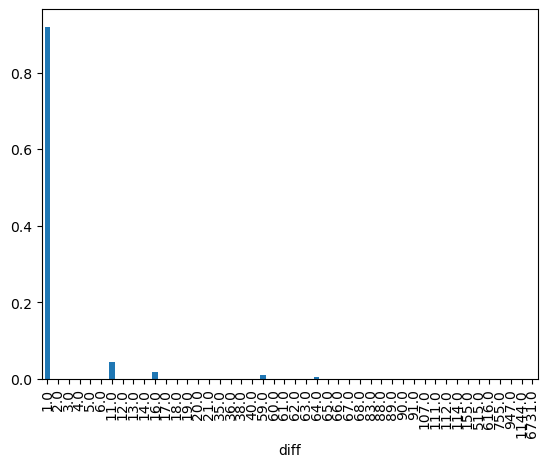

In [155]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [157]:
((df['diff'] < 2) | (df['diff'] == 11) | (df['diff'] == 16) | (df['diff'] == 59)).mean()

0.9932560146707772

In [159]:
#Отлично (не все выходные еще учтены)

#### 5.4 1day

In [164]:
for stock in tqdm(stocks):
    
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

    #print(stock)
    # assert (df['time'].sort_values()  == df['time']).all(), f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}'
    # assert not df['time'].duplicated().any(), f'{stock} duplicated: {df['time'].duplicated().sum()}'
    # assert df.notnull().all().all(), f'{stock} nulls'

    if not (df['time'].sort_values()  == df['time']).all():
        print(f'{stock} not sorted: {(df['time'].sort_values()  != df['time']).sum()}')
        
    if df['time'].duplicated().any():
        print(f'{stock} duplicated: {df['time'].duplicated().sum()}')
        
    if not df.notnull().all().all():
        print(f'{stock} nulls: {df.isnull().sum()}')

100%|███████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 1204.63it/s]


In [166]:
#Нет дублей и данные отсортированы

In [169]:
#Заполняемость

In [171]:
dfs = []
for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
    
    df['diff'] = df['time'].diff() // pd.Timedelta('24 hours')
    dfs += [df.copy()]
df = pd.concat(dfs)
df.shape

100%|███████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 2174.95it/s]


(47577, 6)

<Axes: xlabel='diff'>

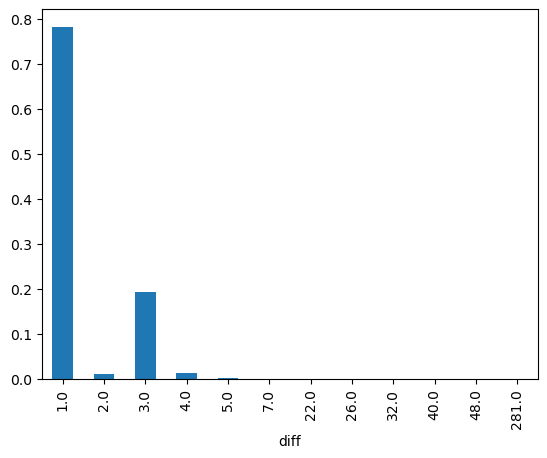

In [173]:
df['diff'].value_counts(normalize=True).sort_index().plot.bar()

In [175]:
threshold = 2
(df['diff'] < 4).mean(), (df['diff'] < 5).mean()

(0.9827437627425016, 0.995481009731593)

In [177]:
#Отлично

# -1. Акции под удаление

In [184]:
#Оставляем только акции, торгующиеся более 1.5 лет
need_days = int(365 * (5/7) * 1.5) 
need_days


391

In [186]:
#1hour
del_stocks_1hour = []

for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

    if df.shape[0] < need_days*14: #14 часов в торг сессии
        del_stocks_1hour += [stock]
        

100%|███████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 2439.28it/s]


In [188]:
len(del_stocks_1hour)

0

In [190]:
del_stocks_1hour

[]

In [193]:
#1day
del_stocks_1day = []

for stock in tqdm(stocks):
    df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

    if df.shape[0] < need_days: #14 часов в торг сессии
        del_stocks_1day += [stock]
        

100%|███████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 4079.19it/s]


In [195]:
len(del_stocks_1day)

0

In [197]:
del_stocks_1day

[]

In [200]:
#Union
del_stocks = set(del_stocks_1hour + del_stocks_1day)

In [202]:
len(del_stocks)

0

In [204]:
del_stocks

set()

In [206]:
#delete
for stock in del_stocks:
    os.remove(f"./data/preproc/1hour/{stock}.pkl")
    os.remove(f"./data/preproc/1day/{stock}.pkl")

In [209]:
import os

In [211]:
[elem.split('.') [0] for elem in os.listdir('./data/preproc/1day/')]

['AFLT',
 'IRAO',
 'MVID',
 'SPBE',
 'MTLRP',
 'SFIN',
 'FEES',
 'LKOH',
 'FESH',
 'MDMG',
 'VKCO',
 'UPRO',
 'SELG',
 'SGZH',
 'ENPG',
 'LSRG',
 'X5',
 'NMTP',
 'PLZL',
 'TATN',
 'AFKS',
 'GMKN',
 'RNFT',
 'YDEX',
 'UWGN',
 'TGKN',
 'HYDR',
 'ABIO',
 'WUSH',
 'GTRK',
 'NLMK',
 'TATNP',
 'ALRS',
 'VSMO',
 'TRNFP',
 'MGNT',
 'IRKT',
 'MTLR',
 'HEAD',
 'RUAL',
 'TMOS',
 'SIBN',
 'SNGS',
 'NVTK',
 'RASP',
 'VTBR',
 'PHOR',
 'T',
 'TRMK',
 'MOEX',
 'SBERP',
 'CHMF',
 'RTKM',
 'SMLT',
 'UNAC',
 'GAZP',
 'ROSN',
 'BELU',
 'FLOT',
 'PIKK',
 'SVAV',
 'POSI',
 'SNGSP',
 'MTSS',
 'MAGN',
 'SBER',
 'BANEP',
 'BSPB']

#### Удалим TMOS

In [213]:
import os
stock = "TMOS"

os.remove(f"./data/preproc/15min/{stock}.pkl")
os.remove(f"./data/preproc/1hour/{stock}.pkl")
os.remove(f"./data/preproc/1day/{stock}.pkl")

### Поправим BELU после сплита

In [220]:
#1 day
stock = "BELU"
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")

mask = df['time'] < pd.Timestamp('2024-08-22')
df.loc[mask, 'close'] = df.loc[mask, 'close'] / 8
df.loc[mask, 'volume'] = df.loc[mask, 'volume'] * 8

dump_pkl(df, f"./data/preproc/1day/{stock}.pkl")

In [222]:
#1 hour
df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")

mask = df['time'] < pd.Timestamp('2024-08-22')
df.loc[mask, 'close'] = df.loc[mask, 'close'] / 8
df.loc[mask, 'volume'] = df.loc[mask, 'volume'] * 8

dump_pkl(df, f"./data/preproc/1hour/{stock}.pkl")

In [224]:
#15 min
df = load_pkl(f"./data/preproc/15min/{stock}.pkl")

mask = df['time'] < pd.Timestamp('2024-08-22')
df.loc[mask, 'close'] = df.loc[mask, 'close'] / 8
df.loc[mask, 'volume'] = df.loc[mask, 'volume'] * 8

dump_pkl(df, f"./data/preproc/15min/{stock}.pkl")

In [226]:
1

1

# -2. Check data

### -2.1 VKCO

In [231]:
#чекнуть сами данные и совпадение с индексом

In [234]:
#15 min

In [236]:
i = -124
stock = "VKCO"

df = load_pkl(f"./data/preproc/15min/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
37071,2025-02-13 17:30:00,323.7,117969.0,VKCO,7.01
37072,2025-02-13 17:45:00,323.7,102128.0,VKCO,7.02


In [238]:
#1hour

df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
9179,2025-02-04 22:00:00,307.6,475954.0,VKCO,6.38
9180,2025-02-04 23:00:00,307.7,230641.0,VKCO,6.37


In [240]:
#1day
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
559,2024-08-20 03:00:00,395.4,2011578.0,VKCO,5.92
560,2024-08-21 03:00:00,381.2,3810843.0,VKCO,5.90


### -2.2 YDEX

In [244]:
#15min
i = -100

stock = "YDEX"
df = load_pkl(f"./data/preproc/15min/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
36830,2025-02-14 12:45:00,4610.0,23795.0,YDEX,7.17
36831,2025-02-14 13:00:00,4603.0,16577.0,YDEX,7.16


In [246]:
#1hour

df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
9137,2025-02-06 18:00:00,4162.0,132284.0,YDEX,6.51
9138,2025-02-06 19:00:00,4190.0,65508.0,YDEX,6.50


In [248]:
#1day
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
579,2024-09-23 03:00:00,4202.5,1880461.0,YDEX,6.03
580,2024-09-24 03:00:00,4160.0,910741.0,YDEX,6.11


### -2.3 SNGS

In [253]:
#15 min
i = -32

stock = "SNGS"
df = load_pkl(f"./data/preproc/15min/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
38404,2025-02-17 15:45:00,28.840,8305.0,SNGS,7.18
38405,2025-02-17 16:00:00,28.895,15698.0,SNGS,7.18


In [255]:
#1hour

df = load_pkl(f"./data/preproc/1hour/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
9590,2025-02-13 16:00:00,28.66,43925.0,SNGS,7.00
9591,2025-02-13 17:00:00,28.72,41815.0,SNGS,7.02


In [257]:
#1day
df = load_pkl(f"./data/preproc/1day/{stock}.pkl")
df.iloc[i-1:i+1]

,time,close,volume,ticker,tmos_close
674,2024-12-27 03:00:00,23.87,467853.0,SNGS,6.01
675,2024-12-30 03:00:00,24.98,587939.0,SNGS,6.27
